In [1]:
import pandas as pd
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
data_path = "../data/combined_data_tesla.csv"

In [3]:
# Load your dataset
df = pd.read_csv(data_path)

# Convert km/h to m/s
df["v_follower"] = df["Smooth Speed Follower"] * (1000 / 3600)
df["v_leader"] = df["Smooth Speed Leader"] * (1000 / 3600)
df.head()


,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader
0,0,750.00,85.910,86.190,85.8574,86.2418,29.962409,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.849278,23.956056
1,1,750.02,85.870,86.245,85.8576,86.2388,29.967962,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.849333,23.955222
2,2,750.04,85.885,86.300,85.8590,86.2394,29.956856,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.849722,23.955389
3,3,750.06,85.900,86.295,85.8616,86.2412,29.951064,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.850444,23.955889
4,4,750.08,85.960,86.290,85.8672,86.2428,29.956618,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.852000,23.956333


In [4]:
# Compute relative speed and spacing
df["delta_v"] = df["v_follower"] - df["v_leader"]
df["spacing"] = df["Spacing"]  # Already in meters

# Estimate time step and acceleration
df["dt"] = df["Time"].diff()
df["acc_follower"] = df["v_follower"].diff() / df["dt"]

# Drop the first row (NaN)
df_cleaned = df.dropna(subset=["dt", "acc_follower"])

df_cleaned.head()

,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader,delta_v,spacing,dt,acc_follower
1,1,750.02,85.870,86.245,85.8576,86.2388,29.967962,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.849333,23.955222,-0.105889,29.967962,0.02,0.002778
2,2,750.04,85.885,86.300,85.8590,86.2394,29.956856,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.849722,23.955389,-0.105667,29.956856,0.02,0.019444
3,3,750.06,85.900,86.295,85.8616,86.2412,29.951064,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.850444,23.955889,-0.105444,29.951064,0.02,0.036111
4,4,750.08,85.960,86.290,85.8672,86.2428,29.956618,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.852000,23.956333,-0.104333,29.956618,0.02,0.077778
5,5,750.10,86.020,86.255,85.8742,86.2430,29.956856,../data/Tesla/Short/5_desired/55/35/2.csv,Short,5,55,35,23.853944,23.956389,-0.102444,29.956856,0.02,0.097222


In [5]:
# One-hot encode the 'gap_setting' column
gap_dummies = pd.get_dummies(df_cleaned['gap_setting'], prefix='gap')

# Combine all selected features
features = pd.concat([
    df_cleaned[["spacing", "delta_v", "v_follower", "speed_fluctuation"]],
    gap_dummies
], axis=1)

# Keep the same target: follower accelerationtest
target = df_cleaned["acc_follower"]

In [6]:
features['gap_Medium'] = False
features['gap_Long'] = False
features['gap_XLong'] = False

In [7]:
features

,spacing,delta_v,v_follower,speed_fluctuation,gap_Short,gap_Medium,gap_Long,gap_XLong
1,29.967962,-0.105889,23.849333,35,True,False,False,False
2,29.956856,-0.105667,23.849722,35,True,False,False,False
3,29.951064,-0.105444,23.850444,35,True,False,False,False
4,29.956618,-0.104333,23.852000,35,True,False,False,False
5,29.956856,-0.102444,23.853944,35,True,False,False,False
...,...,...,...,...,...,...,...,...
32256,37.900830,-0.025278,19.624722,35,True,False,False,False
32257,37.900838,-0.026611,19.624111,35,True,False,False,False
32258,37.900846,-0.028833,19.623056,35,True,False,False,False
32259,37.900838,-0.031611,19.621778,35,True,False,False,False


In [8]:
# spacing	delta_v	v_follower	speed_fluctuation	gap_Long	gap_Medium	gap_Short	gap_XLong

In [9]:
# Define the desired column order
gap_columns = ['gap_Long', 'gap_Medium', 'gap_Short', 'gap_XLong']

# Get the other columns in original order (excluding gap_columns)
other_columns = [col for col in features.columns if col not in gap_columns]

# Reorder the DataFrame
features = features[other_columns + gap_columns]

In [10]:
features

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong
1,29.967962,-0.105889,23.849333,35,False,False,True,False
2,29.956856,-0.105667,23.849722,35,False,False,True,False
3,29.951064,-0.105444,23.850444,35,False,False,True,False
4,29.956618,-0.104333,23.852000,35,False,False,True,False
5,29.956856,-0.102444,23.853944,35,False,False,True,False
...,...,...,...,...,...,...,...,...
32256,37.900830,-0.025278,19.624722,35,False,False,True,False
32257,37.900838,-0.026611,19.624111,35,False,False,True,False
32258,37.900846,-0.028833,19.623056,35,False,False,True,False
32259,37.900838,-0.031611,19.621778,35,False,False,True,False


In [11]:
# Function to plot feature-target relationships for a specified index range
def plot_feature_target_range(features, target, start=0, end=100):
    plt.figure(figsize=(18, 5))

    # Slice the data for the specified range
    features_range = features.iloc[start:end]
    target_range = target.iloc[start:end]

    for i, column in enumerate(features_range.columns):
        plt.subplot(1, features.shape[1], i + 1)
        plt.scatter(features_range[column], target_range, alpha=0.6, s=20)
        plt.xlabel(column)
        plt.ylabel("Acceleration (m/s²)")
        plt.title(f"{column} vs Acceleration (Rows {start}–{end})")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

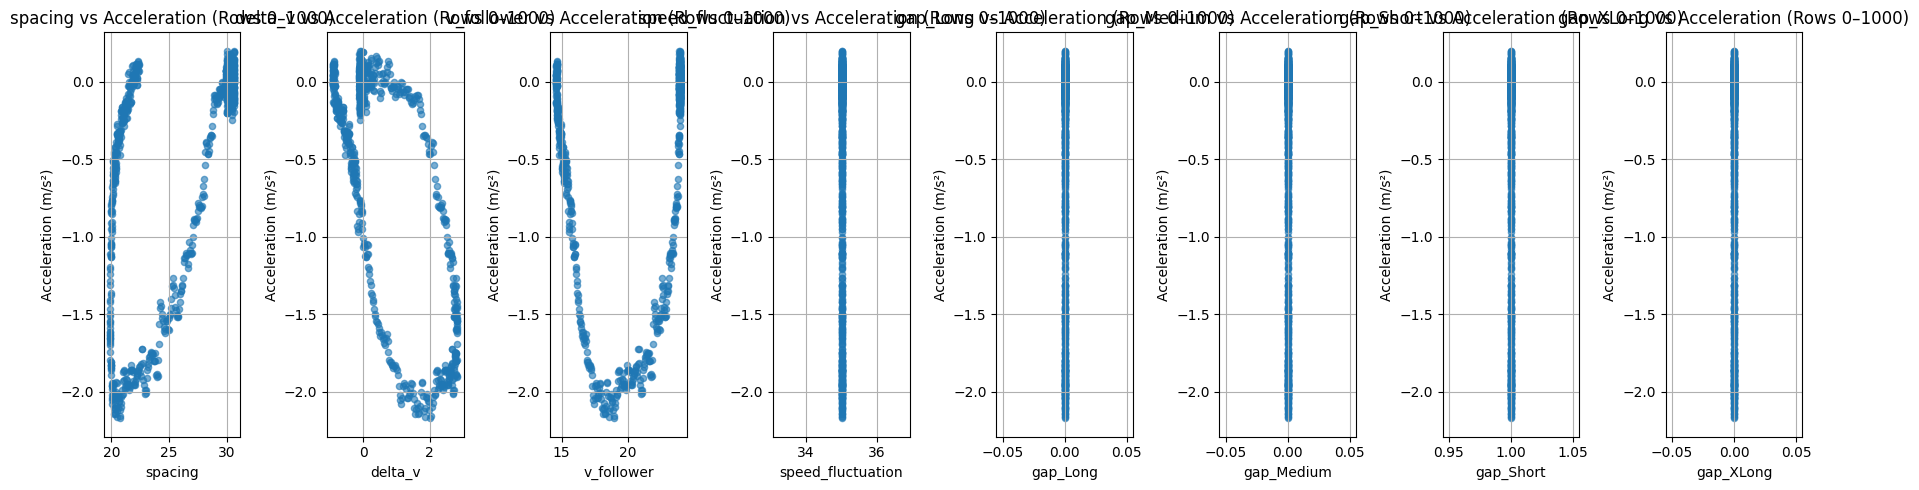

In [12]:
plot_feature_target_range(features, target, start=0, end=1000)

In [13]:
# laod model
# Load the model from the file
rf_model_loaded = joblib.load("rf_model_acceleration.pkl")


In [14]:
# Predict and evaluate
y_pred = rf_model_loaded.predict(features)
rmse = mean_squared_error(target, y_pred)
r2 = r2_score(target, y_pred)

rmse, r2

(0.39221830644068606, -0.20023079871031713)

In [15]:
target

1        0.002778
2        0.019444
3        0.036111
4        0.077778
5        0.097222
           ...   
32256   -0.016667
32257   -0.030556
32258   -0.052778
32259   -0.063889
32260   -0.152778
Name: acc_follower, Length: 32260, dtype: float64

In [16]:
y_pred

array([-0.61811111, -0.61811111, -0.61811111, ...,  0.63516667,
        0.60027778,  0.53811111], shape=(32260,))

In [17]:
# Calculate residuals (errors)
residuals = target - y_pred

## Residual Plot

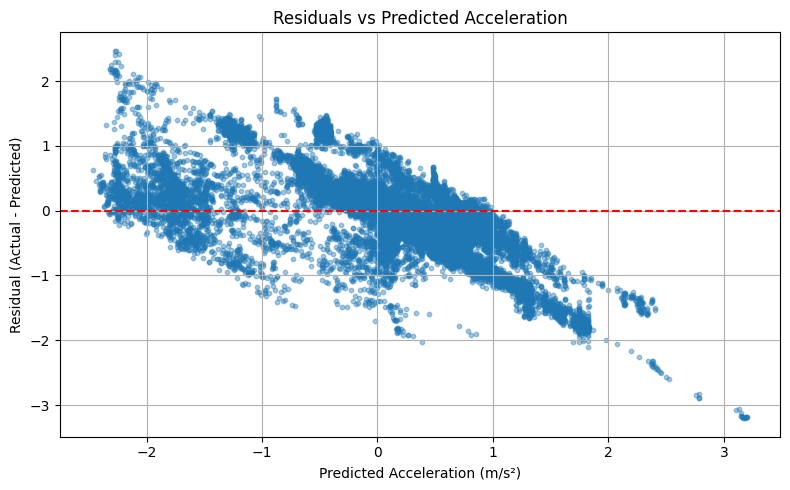

In [18]:
# Plot residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.4, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Acceleration")
plt.xlabel("Predicted Acceleration (m/s²)")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
reformed_df = features.copy()
reformed_df['acc_follower'] = target
reformed_df.head()

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower
1,29.967962,-0.105889,23.849333,35,False,False,True,False,0.002778
2,29.956856,-0.105667,23.849722,35,False,False,True,False,0.019444
3,29.951064,-0.105444,23.850444,35,False,False,True,False,0.036111
4,29.956618,-0.104333,23.852000,35,False,False,True,False,0.077778
5,29.956856,-0.102444,23.853944,35,False,False,True,False,0.097222


In [20]:
reformed_df['pred_acc_follower'] = y_pred
reformed_df.head()

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower
1,29.967962,-0.105889,23.849333,35,False,False,True,False,0.002778,-0.618111
2,29.956856,-0.105667,23.849722,35,False,False,True,False,0.019444,-0.618111
3,29.951064,-0.105444,23.850444,35,False,False,True,False,0.036111,-0.618111
4,29.956618,-0.104333,23.852000,35,False,False,True,False,0.077778,-0.638889
5,29.956856,-0.102444,23.853944,35,False,False,True,False,0.097222,-0.623389


In [21]:
reformed_df['dt'] = 0.02
reformed_df

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower,dt
1,29.967962,-0.105889,23.849333,35,False,False,True,False,0.002778,-0.618111,0.02
2,29.956856,-0.105667,23.849722,35,False,False,True,False,0.019444,-0.618111,0.02
3,29.951064,-0.105444,23.850444,35,False,False,True,False,0.036111,-0.618111,0.02
4,29.956618,-0.104333,23.852000,35,False,False,True,False,0.077778,-0.638889,0.02
5,29.956856,-0.102444,23.853944,35,False,False,True,False,0.097222,-0.623389,0.02
...,...,...,...,...,...,...,...,...,...,...,...
32256,37.900830,-0.025278,19.624722,35,False,False,True,False,-0.016667,0.664889,0.02
32257,37.900838,-0.026611,19.624111,35,False,False,True,False,-0.030556,0.669500,0.02
32258,37.900846,-0.028833,19.623056,35,False,False,True,False,-0.052778,0.635167,0.02
32259,37.900838,-0.031611,19.621778,35,False,False,True,False,-0.063889,0.600278,0.02


In [22]:
import numpy as np

def plot_acc_comparison_from_dataframe(df, actual_col="acc_follower", pred_col="pred_acc_follower", dt_col="dt", limit=(0, 1000),trajectory="Acceleration"):
    # Extract the desired range
    start, end = limit
    df_slice = df.iloc[start:end]

    # Compute time axis using cumulative dt
    time = np.cumsum(df_slice[dt_col].values)

    # Extract actual and predicted acceleration
    actual = df_slice[actual_col].values
    predicted = df_slice[pred_col].values

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(time, actual, label=f"Actual {trajectory}", linewidth=1.5)
    plt.plot(time, predicted, label=f"Predicted {trajectory}", linewidth=1.5, linestyle="--")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{trajectory} (m/s²)")
    plt.title(f"Actual vs Predicted {trajectory} (Rows {start}–{end})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [23]:
# Updated function to include a `limit` parameter for flexible range selection
def plot_actual_vs_predicted_acceleration(y_true, y_pred, limit=(0, 1000)):
    import matplotlib.pyplot as plt

    start, end = limit
    y_true_sample = y_true[start:end].reset_index(drop=True)
    y_pred_sample = pd.Series(y_pred[start:end])

    plt.figure(figsize=(12, 6))
    plt.plot(y_true_sample, label='Actual Acceleration', linewidth=1.5)
    plt.plot(y_pred_sample, label='Predicted Acceleration', linewidth=1.5, linestyle='--')
    plt.title(f"Actual vs Predicted Acceleration (Index {start} to {end})")
    plt.xlabel("Time Step (index)")
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

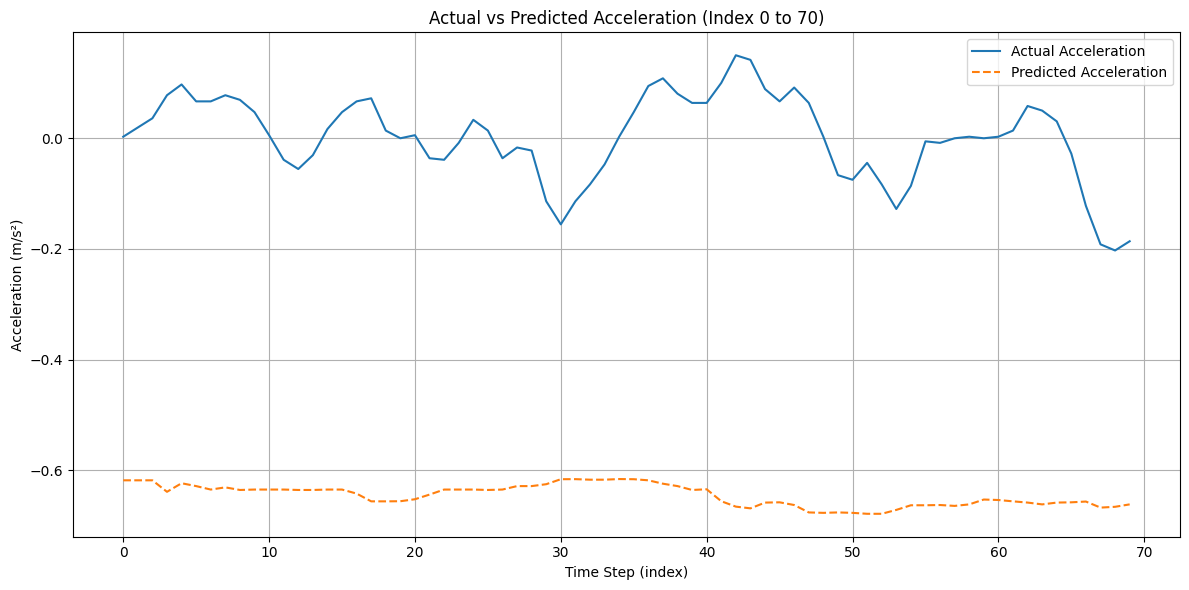

In [24]:
# Example usage with limit range
plot_actual_vs_predicted_acceleration(target.reset_index(drop=True), y_pred, limit=(0, 70))

In [25]:
def compute_predicted_speed(df, acc_col="pred_acc_follower", dt_col="dt", 
                            initial_speed_col="v_follower", output_col="pred_speed_follower"):
    predicted_speed = [df[initial_speed_col].iloc[0]]  # start with the actual initial speed
    for i in range(1, len(df)):
        dt = df[dt_col].iloc[i]
        acc = df[acc_col].iloc[i - 1]
        v_new = predicted_speed[-1] + acc * dt
        predicted_speed.append(v_new)
    
    df[output_col] = predicted_speed
    return df

In [26]:
reformed_df = compute_predicted_speed(reformed_df)

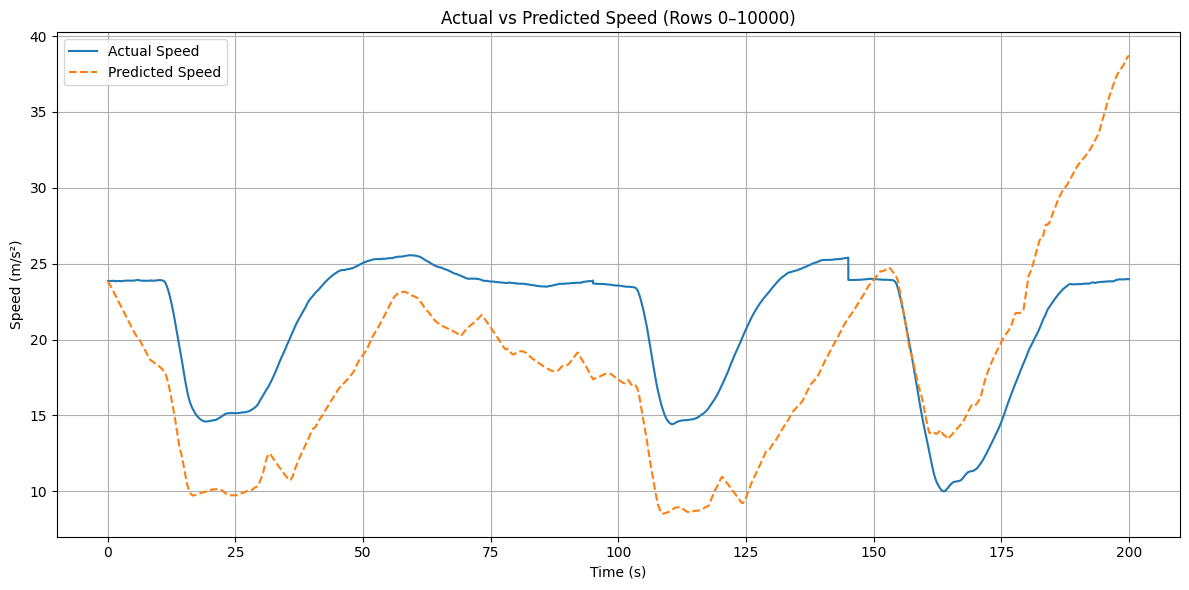

In [27]:
plot_acc_comparison_from_dataframe(reformed_df, actual_col="v_follower", pred_col="pred_speed_follower", dt_col="dt", limit=(0, 10000),trajectory="Speed")